<a href="https://colab.research.google.com/github/2000030914/2000030914/blob/main/25EP01010_CP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install catboost

In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
)

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")
# plt.style.use('seaborn-deep')
RNG = 42

In [ ]:
df = pd.read_csv("liver_cirrhosis.csv")
target_stage = "Stage"

In [ ]:
print("=== Dataset overview ===")
print("Shape:", df.shape)

=== Dataset overview ===
Shape: (25000, 19)


In [ ]:
print("\n--- First 5 rows ---")
print(df.head())


--- First 5 rows ---
   N_Days Status     Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0    2221      C  Placebo  18499   F       N            Y       N     N   
1    1230      C  Placebo  19724   M       Y            N       Y     N   
2    4184      C  Placebo  11839   F       N            N       N     N   
3    2090      D  Placebo  16467   F       N            N       N     N   
4    2105      D  Placebo  21699   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        0.5        149.0     4.04   227.0     598.0   52.70           57.0   
1        0.5        219.0     3.93    22.0     663.0   45.00           75.0   
2        0.5        320.0     3.54    51.0    1243.0  122.45           80.0   
3        0.7        255.0     3.74    23.0    1024.0   77.50           58.0   
4        1.9        486.0     3.54    74.0    1052.0  108.50          109.0   

   Platelets  Prothrombin  Stage  
0      256.0     

In [ ]:
print("\n--- Data types ---")
print(df.dtypes)


--- Data types ---
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage              int64
dtype: object


In [ ]:
print("\n--- Missing values per column ---")
print(df.isna().sum().sort_values(ascending=False))

print("\n--- Basic numeric summary ---")
print(df.describe().T)


--- Missing values per column ---
N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

--- Basic numeric summary ---
                 count          mean          std      min       25%  \
N_Days         25000.0   1887.117040  1091.690918    41.00   1080.00   
Age            25000.0  18495.877080  3737.596616  9598.00  15694.00   
Bilirubin      25000.0      3.402644     4.707491     0.30      0.80   
Cholesterol    25000.0    372.331471   193.668452   120.00    275.00   
Albumin        25000.0      3.486578     0.380488     1.96      3.29   
Copper         25000.0    100.184663    73.184840     4.00     52.00   
Alk_Phos       25000.0   1995.675597  1798.885660   289.

In [ ]:
# Class distribution
if target_stage in df.columns:
    print("\n--- Target class distribution ---")
    print(df[target_stage].value_counts(dropna=False))


--- Target class distribution ---
Stage
2    8441
3    8294
1    8265
Name: count, dtype: int64


<Axes: >

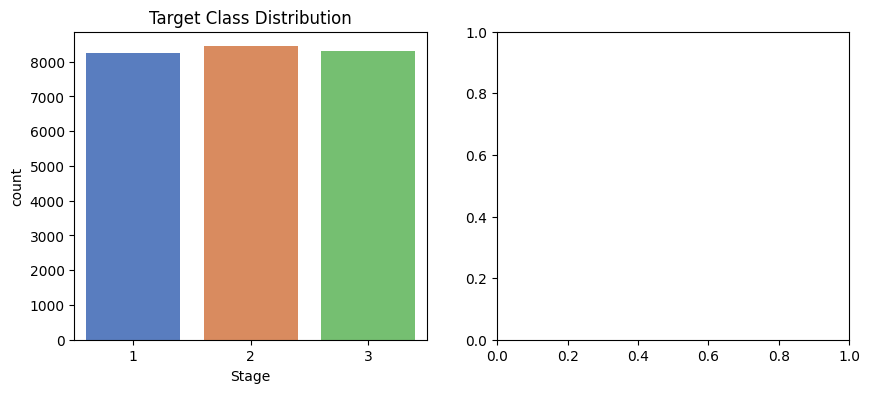

In [ ]:
# Visualize dataset description
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
if target_stage in df.columns:
    sns.countplot(x=target_stage, data=df, palette='muted')
    plt.title("Target Class Distribution")
else:
    plt.text(0.5, 0.5, "No target column found", ha='center')
plt.subplot(1,2,2)

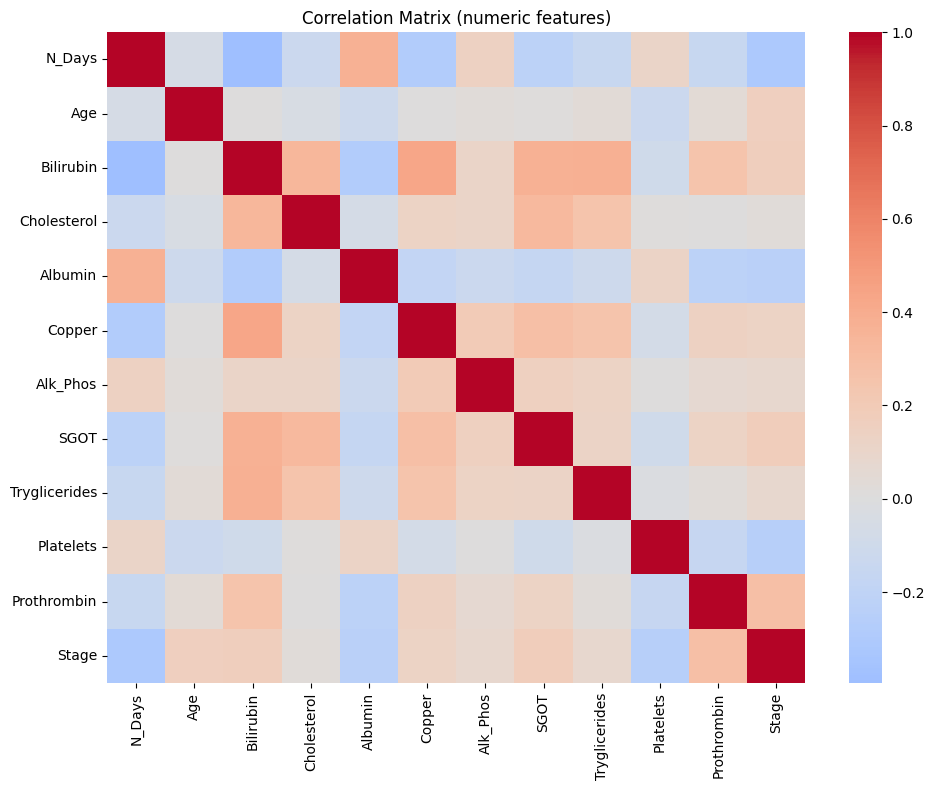

In [ ]:
# Correlation heatmap for numeric features (limit to reasonable number of features)
numeric = df.select_dtypes(include=np.number)
corr = numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix (numeric features)")
plt.tight_layout()
plt.show()

In [ ]:
# Identify categorical and numeric columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

In [ ]:
# Ensure target is encoded and excluded from one-hot or numeric filling
if target_stage in categorical_cols:
    categorical_cols.remove(target_stage)
if target_stage in numerical_cols:
    numerical_cols.remove(target_stage)

In [ ]:
# Encode target (LabelEncoder)
le_stage = LabelEncoder()
df[target_stage] = le_stage.fit_transform(df[target_stage].astype(str))

In [ ]:
# Fill missing numeric values with median (explicit target exclusion)
if len(numerical_cols) > 0:
    df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

In [ ]:
# One-hot encode categorical features (if any)
if len(categorical_cols) > 0:
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

In [ ]:
# Prepare X, y
X = df.drop(columns=[target_stage])
y = df[target_stage]

print("\nFinal features count:", X.shape[1])
print("Final class counts:", Counter(y))


Final features count: 27
Final class counts: Counter({1: 8441, 2: 8294, 0: 8265})


In [ ]:
# ======================= SPLIT & SCALE =======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RNG, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ======================= MODELS =======================
models = {
    "BalancedRF": BalancedRandomForestClassifier(n_estimators=50, max_depth=4, random_state=RNG),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, max_depth=6, criterion='gini',
                                       max_features='sqrt', random_state=RNG),
    "HistGradientBoost": HistGradientBoostingClassifier(max_depth=3, learning_rate=0.2, random_state=RNG),
    "CatBoost": CatBoostClassifier(iterations=80, depth=3, learning_rate=0.25,
                                   l2_leaf_reg=10, verbose=0, random_state=RNG),
    "LightGBM": LGBMClassifier(n_estimators=80, learning_rate=0.25, max_depth=3, reg_lambda=10, random_state=RNG)
}

# ======================= HELPER FUNCTION =======================
def safe_predict_proba(model, X):
    if hasattr(model, "predict_proba"):
        try:
            return model.predict_proba(X)
        except Exception:
            return None
    return None

# ======================= MODEL TRAINING & EVALUATION =======================
results = []

for name, model in models.items():
    print(f"\n=== Training & Evaluating: {name} ===")
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_prob = safe_predict_proba(model, X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')

    auc_macro = np.nan
    auc_micro = np.nan
    num_classes = len(np.unique(y_test))
    if y_prob is not None:
        try:
            if num_classes == 2:
                auc_macro = roc_auc_score(y_test, y_prob[:, 1], average='macro')
                auc_micro = roc_auc_score(y_test, y_prob[:, 1], average='micro')
            else:
                auc_macro = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
                auc_micro = roc_auc_score(y_test, y_prob, multi_class='ovr', average='micro')
        except Exception:
            pass

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1_Score": f1,
        "AUC_Macro": auc_macro,
        "AUC_Micro": auc_micro,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "estimator": model
    })

    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | AUC_Micro: {auc_micro if not np.isnan(auc_micro) else 'N/A'}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

# ======================= PERFORMANCE SUMMARY =======================
results_df = pd.DataFrame(results)[["Model", "Accuracy", "Precision", "Recall", "F1_Score", "AUC_Macro", "AUC_Micro"]]

print("\n📊 Model Performance Summary:")
print(results_df.to_string(index=False))


=== Training & Evaluating: BalancedRF ===
Accuracy: 0.6627 | F1: 0.6585 | AUC_Micro: 0.8553286488888889

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.74      0.68      2480
           1       0.59      0.49      0.54      2532
           2       0.76      0.76      0.76      2488

    accuracy                           0.66      7500
   macro avg       0.66      0.66      0.66      7500
weighted avg       0.66      0.66      0.66      7500


=== Training & Evaluating: ExtraTrees ===
Accuracy: 0.6824 | F1: 0.6772 | AUC_Micro: 0.8501151466666668

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.76      0.69      2480
           1       0.70      0.51      0.59      2532
           2       0.74      0.78      0.76      2488

    accuracy                           0.68      7500
   macro avg       0.69      0.68      0.68      7500
weighted avg       0.69      0.68  


📊 Comparing Model Performance Across Algorithms...


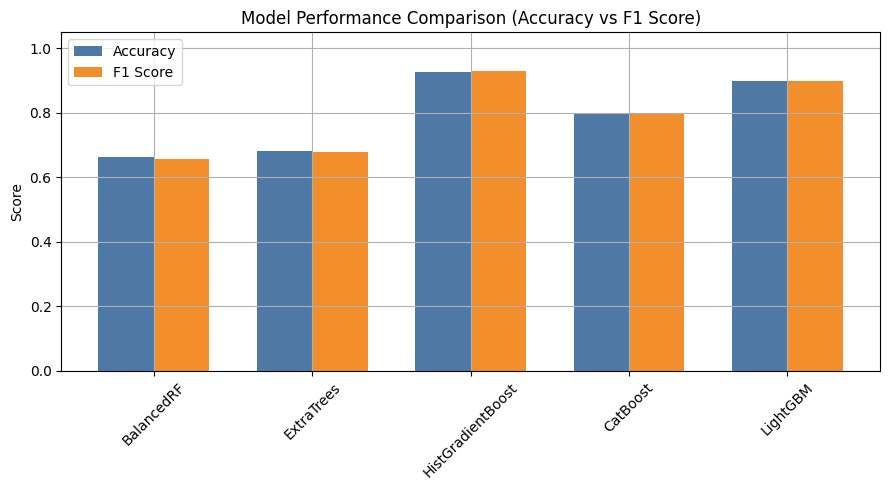

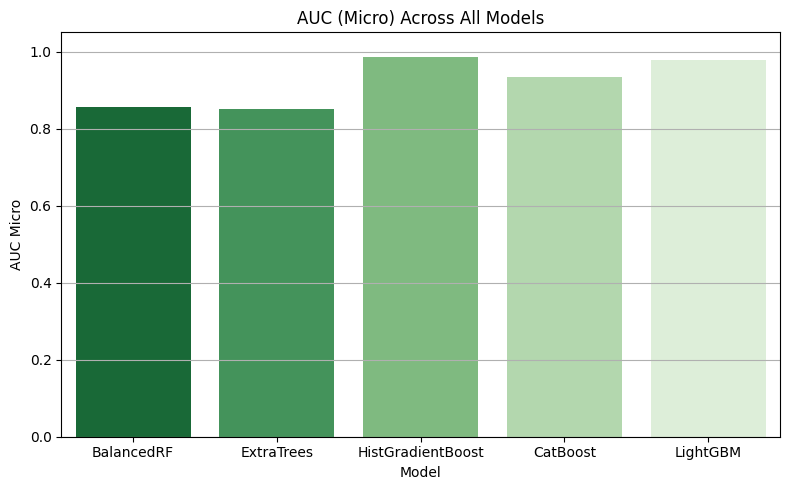


🩸 Outlier Detection for Key Clinical Features:


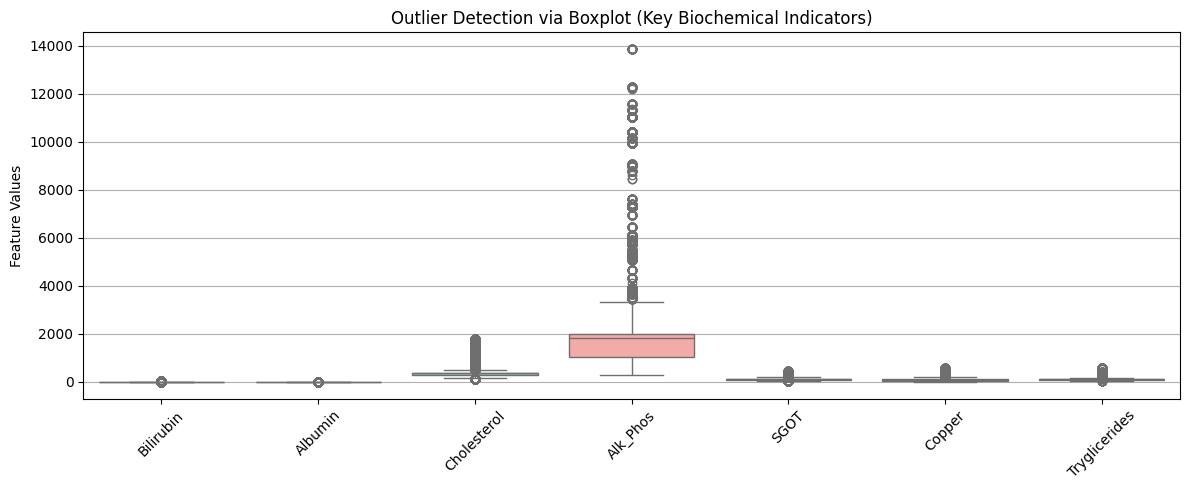

      Feature  Outlier_%
     Alk_Phos       2.71
  Cholesterol       2.49
    Bilirubin       2.08
       Copper       1.75
Tryglicerides       1.34
         SGOT       1.20
      Albumin       0.79

📈 Generating Correlation Heatmap...


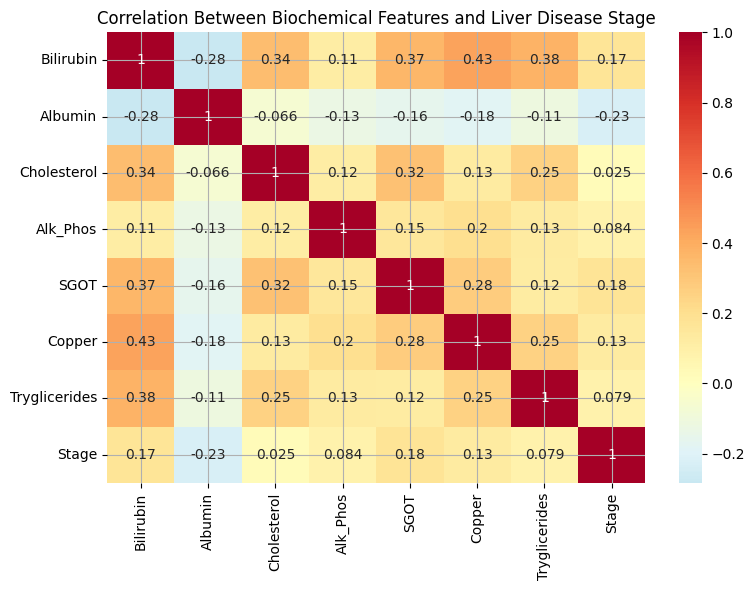


📉 Visualizing Feature Variation Across Stages...


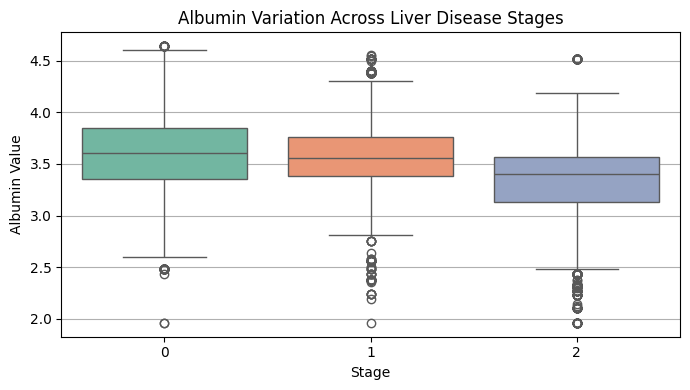

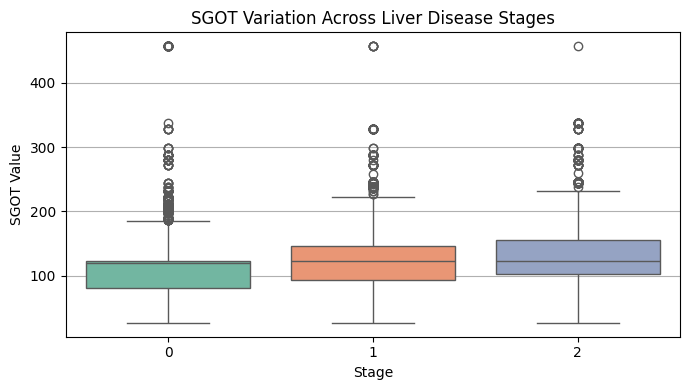

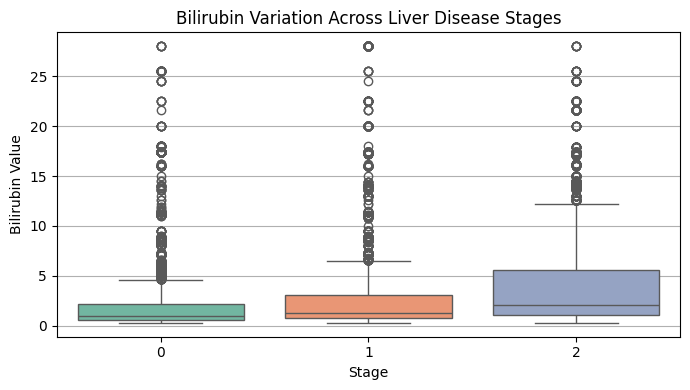


📉 Plotting ROC Curve for Best Model...


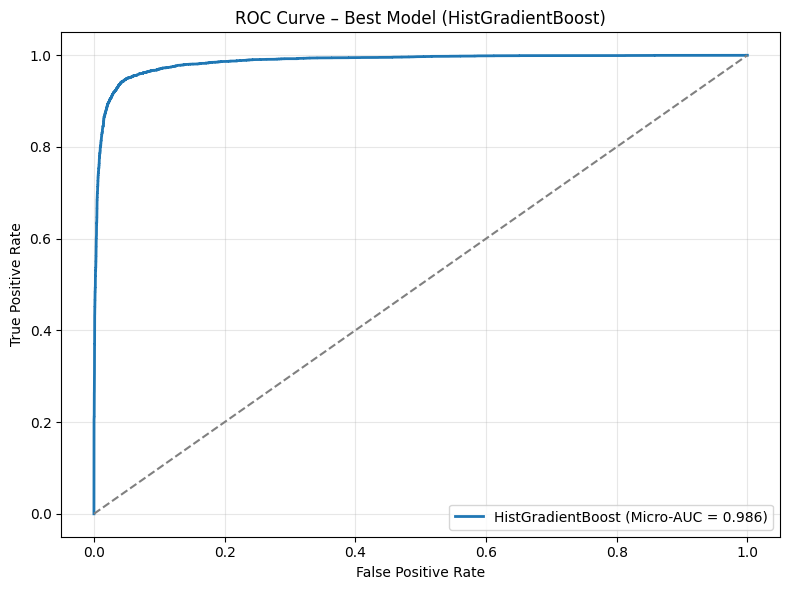


💸 Visualizing Cost-Sensitive Misclassification...


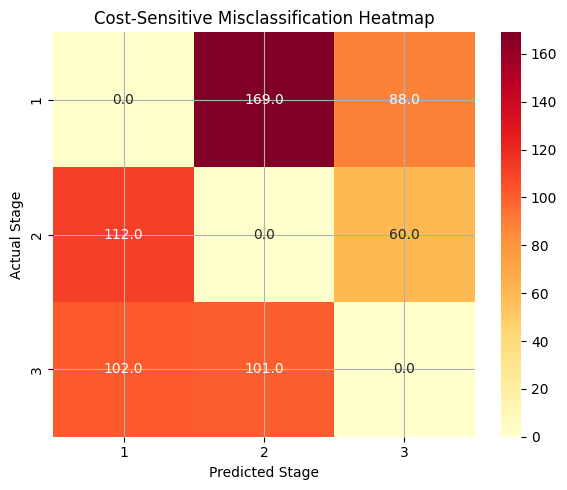


📊 Plotting Stage Prediction Probability Trends...


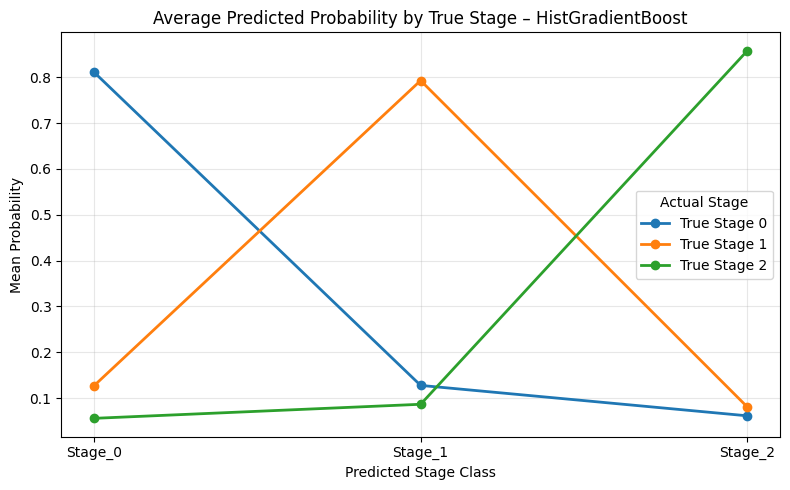


✅ All visualizations generated successfully using best model: HistGradientBoost


In [ ]:
# ======================= ADVANCED VISUALIZATION FOR LIVER STAGE ANALYSIS =======================
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

# ---- 1️⃣ MODEL PERFORMANCE COMPARISON (ACCURACY, F1, AUC) ----
print("\n📊 Comparing Model Performance Across Algorithms...")

metrics_df = results_df[["Model", "Accuracy", "F1_Score", "AUC_Micro"]].set_index("Model")

# Bar chart: Accuracy & F1 Score
plt.figure(figsize=(9,5))
x = np.arange(len(metrics_df))
bar_width = 0.35
plt.bar(x - bar_width/2, metrics_df["Accuracy"], width=bar_width, label="Accuracy", color="#4E79A7")
plt.bar(x + bar_width/2, metrics_df["F1_Score"], width=bar_width, label="F1 Score", color="#F28E2B")
plt.xticks(x, metrics_df.index, rotation=45)
plt.ylim(0, 1.05)
plt.title("Model Performance Comparison (Accuracy vs F1 Score)")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart: AUC Micro across all models
plt.figure(figsize=(8,5))
sns.barplot(x=metrics_df.index, y=metrics_df["AUC_Micro"], palette="Greens_r")
plt.ylim(0, 1.05)
plt.title("AUC (Micro) Across All Models")
plt.ylabel("AUC Micro")
plt.xlabel("Model")
plt.tight_layout()
plt.show()

# ---- 2️⃣ OUTLIER ANALYSIS (Boxplot + Z-Score detection) ----
numeric_features = ["Bilirubin", "Albumin", "Cholesterol", "Alk_Phos", "SGOT", "Copper", "Tryglicerides"]
available_features = [col for col in numeric_features if col in df.columns]

if available_features:
    print("\n🩸 Outlier Detection for Key Clinical Features:")
    plt.figure(figsize=(12,5))
    sns.boxplot(data=df[available_features], palette="pastel")
    plt.title("Outlier Detection via Boxplot (Key Biochemical Indicators)")
    plt.ylabel("Feature Values")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Z-score based outlier summary
    z_scores = np.abs(stats.zscore(df[available_features]))
    outlier_percent = (z_scores > 3).sum(axis=0) / len(df) * 100
    outlier_summary = pd.DataFrame({
        "Feature": available_features,
        "Outlier_%": outlier_percent.round(2)
    }).sort_values("Outlier_%", ascending=False)
    print(outlier_summary.to_string(index=False))

# ---- 3️⃣ CORRELATION HEATMAP ----
print("\n📈 Generating Correlation Heatmap...")
corr_matrix = df[available_features + [target_stage]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlBu_r", center=0)
plt.title("Correlation Between Biochemical Features and Liver Disease Stage")
plt.tight_layout()
plt.show()

# ---- 4️⃣ STAGE-WISE FEATURE VARIATION ----
print("\n📉 Visualizing Feature Variation Across Stages...")
top_corr_features = corr_matrix[target_stage].abs().sort_values(ascending=False)[1:4].index.tolist()
for feat in top_corr_features:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=target_stage, y=feat, data=df, palette="Set2")
    plt.title(f"{feat} Variation Across Liver Disease Stages")
    plt.xlabel("Stage")
    plt.ylabel(f"{feat} Value")
    plt.tight_layout()
    plt.show()

# ---- 5️⃣ ROC CURVE (Best Model) ----
print("\n📉 Plotting ROC Curve for Best Model...")
best_model_name = results_df.loc[results_df["AUC_Micro"].idxmax(), "Model"]
best_result = next(r for r in results if r["Model"] == best_model_name)
y_prob = best_result["y_prob"]

if y_prob is not None:
    num_classes = len(np.unique(y_test))
    plt.figure(figsize=(8,6))
    if num_classes == 2:
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {roc_auc:.3f})", lw=2)
    else:
        y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{best_model_name} (Micro-AUC = {roc_auc:.3f})", lw=2)
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.title(f"ROC Curve – Best Model ({best_model_name})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No probability predictions available for ROC curve.")

# ---- 6️⃣ COST-SENSITIVE MISCLASSIFICATION HEATMAP ----
print("\n💸 Visualizing Cost-Sensitive Misclassification...")
num_stages = len(le_stage.classes_)
cost_matrix = np.abs(np.subtract.outer(np.arange(num_stages), np.arange(num_stages)))
cm = confusion_matrix(y_test, best_result["y_pred"])
cost_impact = cm * cost_matrix
plt.figure(figsize=(6,5))
sns.heatmap(cost_impact, annot=True, fmt='.1f', cmap="YlOrRd",
            xticklabels=le_stage.classes_, yticklabels=le_stage.classes_)
plt.title("Cost-Sensitive Misclassification Heatmap")
plt.xlabel("Predicted Stage")
plt.ylabel("Actual Stage")
plt.tight_layout()
plt.show()

# ---- 7️⃣ STAGE PREDICTION PROBABILITY CURVE ----
print("\n📊 Plotting Stage Prediction Probability Trends...")
if y_prob is not None:
    avg_prob = pd.DataFrame(y_prob, columns=[f"Stage_{i}" for i in range(len(le_stage.classes_))])
    avg_prob["TrueStage"] = y_test.values
    stage_means = avg_prob.groupby("TrueStage").mean().T

    plt.figure(figsize=(8,5))
    for col in stage_means.columns:
        plt.plot(stage_means.index, stage_means[col], marker='o', lw=2, label=f"True Stage {col}")
    plt.title(f"Average Predicted Probability by True Stage – {best_model_name}")
    plt.xlabel("Predicted Stage Class")
    plt.ylabel("Mean Probability")
    plt.legend(title="Actual Stage")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Cannot plot stage probability trends — no probability data found.")

print(f"\n✅ All visualizations generated successfully using best model: {best_model_name}")


In [ ]:
# ======================= BEST MODEL SELECTION =======================
best_model_name = results_df.iloc[results_df["AUC_Micro"].idxmax()]["Model"]
print(f"\n🏆 Best performing model based on AUC Micro: {best_model_name}")


🏆 Best performing model based on AUC Micro: HistGradientBoost


In [ ]:
# ======================= SAVE SUMMARY =======================
results_df.to_csv("liver_model_performance_summary.csv", index=False)
print("\n✅ Saved model summary to 'liver_model_performance_summary.csv'")


✅ Saved model summary to 'liver_model_performance_summary.csv'
